# ***Deep Learning based Car Identification***
##### *- Automotive, Surveillance, Object Detection & Localisation*

***Project By:***<br>
Premjeet Kumar https://www.linkedin.com/in/premjeet-kumar/<br>
Hari Samynaath S https://www.linkedin.com/in/harinaathan/<br>
Veena Raju https://www.linkedin.com/in/veena-raju-1b16b513b/<br>
Javed Bhai https://www.linkedin.com/in/javedbhai/<br>
Surabhi Joshi https://www.linkedin.com/in/surabhi-joshi-4452788/<br>

***Project For:***<br>
Captstone project for **Post Graduate Program in Artificial Intelligence and Machine Learning**<br>
with *GreatLakes & Texas McCombs School of Business, The University of Texas at Austin*

**CONTEXT:**<br>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is predicted from the image of interest. For example a car moving on the road can be easily identi ied by a camera as make of the car, type, colour, number plates etc.<br><br>
**DATA DESCRIPTION:**<br>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.<br>
<br>
‣ *Train Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Test Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Train Annotation:* Consists of bounding box region for training images.<br>
‣ *Test Annotation:* Consists of bounding box region for testing images.<br>

### **MILESTONE 1:**
‣ *Step 1:* Import the data<br>
‣ *Step 2:* Map training and testing images to its classes.<br>
‣ *Step 3:* Map training and testing images to its annotations.<br>
‣ *Step 4:* Display images with bounding box<br>
‣ *Output:* Images mapped to its class and annotation ready to be used for deep learning<br>

In [1]:
# import necessary libraries for Milestone 1
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import re, cv2

from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read the car/class names
carsMaster = pd.read_csv("Car names and make.csv",header=None)
carsMaster.columns=["fullNames"]
carsMaster.head()

fullNames
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

In [3]:
# lets review the name lengths
carsMaster["wCounts"] = carsMaster["fullNames"].apply(lambda x: len(x.split()))
carsMaster.wCounts.value_counts()

4    132
5     44
6     14
7      6
Name: wCounts, dtype: int64

In [4]:
# lets review the 7 word long names
print(carsMaster.loc[carsMaster.wCounts==7,["fullNames"]].values)

[['Chevrolet Silverado 1500 Hybrid Crew Cab 2012']
 ['Chevrolet Corvette Ron Fellows Edition Z06 2007']
 ['Chevrolet Silverado 1500 Classic Extended Cab 2007']
 ['Dodge Ram Pickup 3500 Crew Cab 2010']
 ['Dodge Ram Pickup 3500 Quad Cab 2009']
 ['Ford F-450 Super Duty Crew Cab 2012']]


In [5]:
# before we process any information from the fullNames, lets remove any path separator '/' in the class names
carsMaster["fullNames"] = carsMaster["fullNames"].apply(lambda x: '-'.join(x.split('/')))

In [6]:
# lets first separate the OEM name & Year-of-Make data and review again
carsMaster["OEM"] = carsMaster["fullNames"].apply(lambda x: x.split()[0])
carsMaster["YEAR"] = carsMaster["fullNames"].apply(lambda x: x.split()[-1])

# also pickup the second word to verify if it was part of OEM name or Model name
carsMaster["chk"] = carsMaster["fullNames"].apply(lambda x: x.split()[1])
carsMaster.head()

fullNames  wCounts    OEM  YEAR      chk
0  AM General Hummer SUV 2000        5     AM  2000  General
1         Acura RL Sedan 2012        4  Acura  2012       RL
2         Acura TL Sedan 2012        4  Acura  2012       TL
3        Acura TL Type-S 2008        4  Acura  2008       TL
4        Acura TSX Sedan 2012        4  Acura  2012      TSX

In [7]:
# lets review on basis of OEM
dtmp = carsMaster.groupby(by="OEM")["chk"].unique()
dtmp

OEM
AM                                                       [General]
Acura                                  [RL, TL, TSX, Integra, ZDX]
Aston                                                     [Martin]
Audi                    [RS, A5, TTS, R8, V8, 100, TT, S6, S5, S4]
BMW              [ActiveHybrid, 1, 3, 6, X5, X6, M3, M5, M6, X3...
Bentley                            [Continental, Arnage, Mulsanne]
Bugatti                                                   [Veyron]
Buick                            [Regal, Rainier, Verano, Enclave]
Cadillac                                    [CTS-V, SRX, Escalade]
Chevrolet        [Silverado, Corvette, Traverse, Camaro, HHR, I...
Chrysler                [Aspen, Sebring, Town, 300, Crossfire, PT]
Daewoo                                                    [Nubira]
Dodge            [Caliber, Caravan, Ram, Sprinter, Journey, Dak...
Eagle                                                      [Talon]
FIAT                                                      

In [8]:
# the suspects for 2 word OEM names are whereever there are only 1 uniques against the extracted first name of the OE
# lets try to short list those and review better
carsMaster.loc[carsMaster.OEM.isin(dtmp.loc[carsMaster.groupby(by="OEM")["chk"].nunique()==1].index)]

fullNames  wCounts         OEM  YEAR  \
0                  AM General Hummer SUV 2000        5          AM  2000   
7    Aston Martin V8 Vantage Convertible 2012        6       Aston  2012   
8          Aston Martin V8 Vantage Coupe 2012        6       Aston  2012   
9        Aston Martin Virage Convertible 2012        5       Aston  2012   
10             Aston Martin Virage Coupe 2012        5       Aston  2012   
44       Bugatti Veyron 16.4 Convertible 2009        5     Bugatti  2009   
45             Bugatti Veyron 16.4 Coupe 2009        5     Bugatti  2009   
81                   Daewoo Nubira Wagon 2002        4      Daewoo  2002   
97                 Eagle Talon Hatchback 1998        4       Eagle  1998   
98                       FIAT 500 Abarth 2012        4        FIAT  2012   
99                  FIAT 500 Convertible 2012        4        FIAT  2012   
104                   Fisker Karma Sedan 2012        4      Fisker  2012   
122                Geo Metro Convertible 1993        4         Geo  1993   
142                   Isuzu Ascender SUV 2008        4       Isuzu  2008   
143                        Jaguar XK XKR 2012        4      Jaguar  2012   
153           Land Rover Range Rover SUV 2012        6        Land  2012   
154                   Land Rover LR2 SUV 2012        5        Land  2012   
155               Lincoln Town Car Sedan 2011        5     Lincoln  2011   
156     MINI Cooper Roadster Convertible 2012        5        MINI  2012   
157        Maybach Landaulet Convertible 2012        4     Maybach  2012   
158                    Mazda Tribute SUV 2011        4       Mazda  2011   
159                McLaren MP4-12C Coupe 2012        4     McLaren  2012   
166              Mitsubishi Lancer Sedan 2012        4  Mitsubishi  2012   
171                  Plymouth Neon Coupe 1999        4    Plymouth  1999   
172               Porsche Panamera Sedan 2012        4     Porsche  2012   
173            Ram C-V Cargo Van Minivan 2012        6         Ram  2012   
177                   Scion xD Hatchback 2012        4       Scion  2012   
178                Spyker C8 Convertible 2009        4      Spyker  2009   
179                      Spyker C8 Coupe 2009        4      Spyker  2009   
184                  Tesla Model S Sedan 2012        5       Tesla  2012   
195             smart fortwo Convertible 2012        4       smart  2012   

           chk  
0      General  
7       Martin  
8       Martin  
9       Martin  
10      Martin  
44      Veyron  
45      Veyron  
81      Nubira  
97       Talon  
98         500  
99         500  
104      Karma  
122      Metro  
142   Ascender  
143         XK  
153      Rover  
154      Rover  
155       Town  
156     Cooper  
157  Landaulet  
158    Tribute  
159    MP4-12C  
166     Lancer  
171       Neon  
172   Panamera  
173        C-V  
177         xD  
178         C8  
179         C8  
184      Model  
195     fortwo

In [9]:
# manually listing the OEM names with 2 words based on above table
twinWordOE = ['AM', 'Aston', 'Land']
twinWordOE

['AM', 'Aston', 'Land']

In [10]:
# lets update the OEM  names accordingly
dtmp = carsMaster.loc[carsMaster.OEM.isin(twinWordOE)]
carsMaster.loc[carsMaster.OEM.isin(twinWordOE),["OEM"]] = dtmp.fullNames.apply(lambda x: x.split()[:2])
carsMaster.loc[dtmp.index]

fullNames  wCounts              OEM  YEAR  \
0                  AM General Hummer SUV 2000        5    [AM, General]  2000   
7    Aston Martin V8 Vantage Convertible 2012        6  [Aston, Martin]  2012   
8          Aston Martin V8 Vantage Coupe 2012        6  [Aston, Martin]  2012   
9        Aston Martin Virage Convertible 2012        5  [Aston, Martin]  2012   
10             Aston Martin Virage Coupe 2012        5  [Aston, Martin]  2012   
153           Land Rover Range Rover SUV 2012        6    [Land, Rover]  2012   
154                   Land Rover LR2 SUV 2012        5    [Land, Rover]  2012   

         chk  
0    General  
7     Martin  
8     Martin  
9     Martin  
10    Martin  
153    Rover  
154    Rover

In [11]:
# lets us now extract the model name
[w for w in carsMaster.fullNames[10].split() if w not in carsMaster.OEM[10] and w != str(carsMaster.YEAR[10])]

['Virage', 'Coupe']

In [12]:
# update model names in the dataframe
carsMaster["MODEL"] = carsMaster.apply(lambda row: [w for w in row["fullNames"].split() if w not in row["OEM"] and w!=str(row["YEAR"])],axis=1)
display(carsMaster.loc[dtmp.index])
display(carsMaster.sample(5))

fullNames  wCounts              OEM  YEAR  \
0                  AM General Hummer SUV 2000        5    [AM, General]  2000   
7    Aston Martin V8 Vantage Convertible 2012        6  [Aston, Martin]  2012   
8          Aston Martin V8 Vantage Coupe 2012        6  [Aston, Martin]  2012   
9        Aston Martin Virage Convertible 2012        5  [Aston, Martin]  2012   
10             Aston Martin Virage Coupe 2012        5  [Aston, Martin]  2012   
153           Land Rover Range Rover SUV 2012        6    [Land, Rover]  2012   
154                   Land Rover LR2 SUV 2012        5    [Land, Rover]  2012   

         chk                       MODEL  
0    General               [Hummer, SUV]  
7     Martin  [V8, Vantage, Convertible]  
8     Martin        [V8, Vantage, Coupe]  
9     Martin       [Virage, Convertible]  
10    Martin             [Virage, Coupe]  
153    Rover                [Range, SUV]  
154    Rover                  [LR2, SUV]

fullNames  wCounts        OEM  YEAR  \
100                      Ferrari FF Coupe 2012        4    Ferrari  2012   
74   Chevrolet Silverado 1500 Regular Cab 2012        6  Chevrolet  2012   
3                         Acura TL Type-S 2008        4      Acura  2008   
31                             BMW X5 SUV 2007        4        BMW  2007   
6                     Acura ZDX Hatchback 2012        4      Acura  2012   

           chk                            MODEL  
100         FF                      [FF, Coupe]  
74   Silverado  [Silverado, 1500, Regular, Cab]  
3           TL                     [TL, Type-S]  
31          X5                        [X5, SUV]  
6          ZDX                 [ZDX, Hatchback]

In [13]:
# lets review the model names and extract model type information from it
carsMaster["mwCounts"] = carsMaster.MODEL.apply(lambda x: len(x))

In [14]:
# review model name lenghts
carsMaster.mwCounts.value_counts()

2    137
3     42
4     11
5      6
Name: mwCounts, dtype: int64

In [15]:
# display few significant model names based on word counts
carsMaster.loc[carsMaster.mwCounts==5,"MODEL"]

53          [Silverado, 1500, Hybrid, Crew, Cab]
56        [Corvette, Ron, Fellows, Edition, Z06]
69     [Silverado, 1500, Classic, Extended, Cab]
85                [Ram, Pickup, 3500, Crew, Cab]
86                [Ram, Pickup, 3500, Quad, Cab]
105              [F-450, Super, Duty, Crew, Cab]
Name: MODEL, dtype: object

In [16]:
carsMaster.loc[carsMaster.mwCounts==4,"MODEL"]

38     [Continental, Supersports, Conv., Convertible]
43                 [Continental, Flying, Spur, Sedan]
52                         [Escalade, EXT, Crew, Cab]
68                  [Silverado, 2500HD, Regular, Cab]
73                   [Silverado, 1500, Extended, Cab]
74                    [Silverado, 1500, Regular, Cab]
77                      [Town, and, Country, Minivan]
124                              [H2, SUT, Crew, Cab]
151               [Gallardo, LP, 570-4, Superleggera]
173                        [C-V, Cargo, Van, Minivan]
174           [Phantom, Drophead, Coupe, Convertible]
Name: MODEL, dtype: object

In [17]:
carsMaster.loc[carsMaster.mwCounts==3,"MODEL"]

5                   [Integra, Type, R]
7           [V8, Vantage, Convertible]
8                 [V8, Vantage, Coupe]
11                [RS, 4, Convertible]
24                     [TT, RS, Coupe]
25            [ActiveHybrid, 5, Sedan]
26            [1, Series, Convertible]
27                  [1, Series, Coupe]
28                  [3, Series, Sedan]
29                  [3, Series, Wagon]
30            [6, Series, Convertible]
41            [Continental, GT, Coupe]
42            [Continental, GT, Coupe]
44         [Veyron, 16.4, Convertible]
45               [Veyron, 16.4, Coupe]
61                [Tahoe, Hybrid, SUV]
63               [Express, Cargo, Van]
64              [Avalanche, Crew, Cab]
66             [Malibu, Hybrid, Sedan]
71               [Monte, Carlo, Coupe]
80          [PT, Cruiser, Convertible]
87              [Sprinter, Cargo, Van]
89                 [Dakota, Crew, Cab]
90                 [Dakota, Club, Cab]
102         [458, Italia, Convertible]
103               [458, I

it should be noted that, Cab & Van comes with 2 word coach type<br>
othewise, almost every other words are part of model name only<br>
hence lets separate the coach type

In [18]:
# extract the TYPE info
carsMaster["TYPE"] = carsMaster.MODEL.apply(lambda x: x[-1])

In [19]:
# review
carsMaster.TYPE.unique()

array(['SUV', 'Sedan', 'Type-S', 'R', 'Hatchback', 'Convertible', 'Coupe',
       'Wagon', 'GS', 'Cab', 'ZR1', 'Z06', 'SS', 'Van', 'Minivan',
       'SRT-8', 'SRT8', 'Abarth', 'SuperCab', 'IPL', 'XKR',
       'Superleggera'], dtype=object)

**findings**<br>
* the type IPL hides Coupe type before it<br>
* 'Type-S', 'R', 'GS',  'ZR1', 'Z06', 'Abarth', 'XKR' types are not coach types, hence to be markes as unKnown<br>
* 'SS', 'SRT-8', 'SRT8' could be considered as car type (though not coach type) as they are technology/class of car<br>

lets update the TYPE accordingly

In [20]:
# lets update the TYPE
for t in ['Type-S', 'R', 'GS',  'ZR1', 'Z06', 'Abarth', 'XKR']:
    carsMaster.loc[carsMaster.TYPE == t,"TYPE"] = 'UnKnown'
carsMaster.loc[carsMaster.TYPE == 'IPL',"TYPE"] = "Coupe"
carsMaster.loc[carsMaster.TYPE == 'Cab',"TYPE"] = carsMaster.loc[carsMaster.TYPE == 'Cab',"MODEL"].apply(lambda x: x[-2:])
carsMaster.loc[carsMaster.TYPE == 'Van',"TYPE"] = carsMaster.loc[carsMaster.TYPE == 'Van',"MODEL"].apply(lambda x: x[-2:])
carsMaster.loc[carsMaster.TYPE == 'SRT-8',"TYPE"] = "SRT8"

In [21]:
# now lets update the MODEL name excluding the TYPE information
carsMaster["MODEL"] = carsMaster.apply(lambda row: [w for w in row["fullNames"].split() if w not in row["OEM"] and w!=str(row["YEAR"]) and w not in row["TYPE"]],axis=1)
display(carsMaster.sample(15))

fullNames  wCounts            OEM  YEAR  \
47                       Buick Rainier SUV 2007        4          Buick  2007   
73   Chevrolet Silverado 1500 Extended Cab 2012        6      Chevrolet  2012   
70                   Chevrolet Express Van 2007        4      Chevrolet  2007   
152               Lamborghini Diablo Coupe 2001        4    Lamborghini  2001   
35                      BMW M6 Convertible 2010        4            BMW  2010   
85          Dodge Ram Pickup 3500 Crew Cab 2010        7          Dodge  2010   
183                       Suzuki SX4 Sedan 2012        4         Suzuki  2012   
54          Chevrolet Corvette Convertible 2012        4      Chevrolet  2012   
162           Mercedes-Benz SL-Class Coupe 2009        4  Mercedes-Benz  2009   
45               Bugatti Veyron 16.4 Coupe 2009        5        Bugatti  2009   
14                           Audi R8 Coupe 2012        4           Audi  2012   
146                       Jeep Liberty SUV 2012        4           Jeep  2012   
186                     Toyota Camry Sedan 2012        4         Toyota  2012   
93                       Dodge Durango SUV 2012        4          Dodge  2012   
42            Bentley Continental GT Coupe 2007        5        Bentley  2007   

             chk                MODEL  mwCounts             TYPE  
47       Rainier            [Rainier]         2              SUV  
73     Silverado    [Silverado, 1500]         4  [Extended, Cab]  
70       Express                   []         2   [Express, Van]  
152       Diablo             [Diablo]         2            Coupe  
35            M6                 [M6]         2      Convertible  
85           Ram  [Ram, Pickup, 3500]         5      [Crew, Cab]  
183          SX4                [SX4]         2            Sedan  
54      Corvette           [Corvette]         2      Convertible  
162     SL-Class           [SL-Class]         2            Coupe  
45        Veyron       [Veyron, 16.4]         3            Coupe  
14            R8                 [R8]         2            Coupe  
146      Liberty            [Liberty]         2              SUV  
186        Camry              [Camry]         2            Sedan  
93       Durango            [Durango]         2              SUV  
42   Continental    [Continental, GT]         3            Coupe

In [22]:
# lets properly combine the OEM names & Model Names without lists
carsMaster["OEM"] = carsMaster["OEM"].apply(lambda x: x if type(x)==str else '_'.join(x))
carsMaster["MODEL"] = carsMaster["MODEL"].apply(lambda x: x if type(x)==str else '_'.join(x))
carsMaster["TYPE"] = carsMaster["TYPE"].apply(lambda x: x if type(x)==str else '_'.join(x))
display(carsMaster.sample(15))

fullNames  wCounts            OEM  YEAR  \
162     Mercedes-Benz SL-Class Coupe 2009        4  Mercedes-Benz  2009   
27                BMW 1 Series Coupe 2012        5            BMW  2012   
92             Dodge Challenger SRT8 2011        4          Dodge  2011   
126            Honda Odyssey Minivan 2007        4          Honda  2007   
125            Honda Odyssey Minivan 2012        4          Honda  2012   
2                     Acura TL Sedan 2012        4          Acura  2012   
82               Dodge Caliber Wagon 2012        4          Dodge  2012   
154               Land Rover LR2 SUV 2012        5     Land_Rover  2012   
144                 Jeep Patriot SUV 2012        4           Jeep  2012   
9    Aston Martin Virage Convertible 2012        5   Aston_Martin  2012   
137             Hyundai Sonata Sedan 2012        4        Hyundai  2012   
100                 Ferrari FF Coupe 2012        4        Ferrari  2012   
153       Land Rover Range Rover SUV 2012        6     Land_Rover  2012   
127               Honda Accord Coupe 2012        4          Honda  2012   
192              Volvo C30 Hatchback 2012        4          Volvo  2012   

            chk       MODEL  mwCounts         TYPE  
162    SL-Class    SL-Class         2        Coupe  
27            1    1_Series         3        Coupe  
92   Challenger  Challenger         2         SRT8  
126     Odyssey     Odyssey         2      Minivan  
125     Odyssey     Odyssey         2      Minivan  
2            TL          TL         2        Sedan  
82      Caliber     Caliber         2        Wagon  
154       Rover         LR2         2          SUV  
144     Patriot     Patriot         2          SUV  
9        Martin      Virage         2  Convertible  
137      Sonata      Sonata         2        Sedan  
100          FF          FF         2        Coupe  
153       Rover       Range         2          SUV  
127      Accord      Accord         2        Coupe  
192         C30         C30         2    Hatchback

In [23]:
# lets drop & rearrange the master data
carsMaster = carsMaster[["fullNames","OEM","MODEL","TYPE","YEAR"]]
carsMaster.sample(15)

fullNames            OEM  \
87                   Dodge Sprinter Cargo Van 2009          Dodge   
3                             Acura TL Type-S 2008          Acura   
65                        Chevrolet Cobalt SS 2010      Chevrolet   
78                         Chrysler 300 SRT-8 2010       Chrysler   
53   Chevrolet Silverado 1500 Hybrid Crew Cab 2012      Chevrolet   
86             Dodge Ram Pickup 3500 Quad Cab 2009          Dodge   
149                Lamborghini Reventon Coupe 2008    Lamborghini   
74       Chevrolet Silverado 1500 Regular Cab 2012      Chevrolet   
187                      Toyota Corolla Sedan 2012         Toyota   
8               Aston Martin V8 Vantage Coupe 2012   Aston_Martin   
52             Cadillac Escalade EXT Crew Cab 2007       Cadillac   
160       Mercedes-Benz 300-Class Convertible 1993  Mercedes-Benz   
163               Mercedes-Benz E-Class Sedan 2012  Mercedes-Benz   
64               Chevrolet Avalanche Crew Cab 2012      Chevrolet   
182                      Suzuki SX4 Hatchback 2012         Suzuki   

                     MODEL         TYPE  YEAR  
87                Sprinter    Cargo_Van  2009  
3                TL_Type-S      UnKnown  2008  
65                  Cobalt           SS  2010  
78               300_SRT-8         SRT8  2010  
53   Silverado_1500_Hybrid     Crew_Cab  2012  
86         Ram_Pickup_3500     Quad_Cab  2009  
149               Reventon        Coupe  2008  
74          Silverado_1500  Regular_Cab  2012  
187                Corolla        Sedan  2012  
8               V8_Vantage        Coupe  2012  
52            Escalade_EXT     Crew_Cab  2007  
160              300-Class  Convertible  1993  
163                E-Class        Sedan  2012  
64               Avalanche     Crew_Cab  2012  
182                    SX4    Hatchback  2012

In [24]:
# review number of unique classes
print("Number of unique classes:")
print("OEMs :",carsMaster.OEM.nunique())
print("MODELs :",carsMaster.MODEL.nunique())
print("TYPEs :",carsMaster.TYPE.nunique())
print("YEARs :",carsMaster.YEAR.nunique())

Number of unique classes:
OEMs : 49
MODELs : 173
TYPEs : 23
YEARs : 16


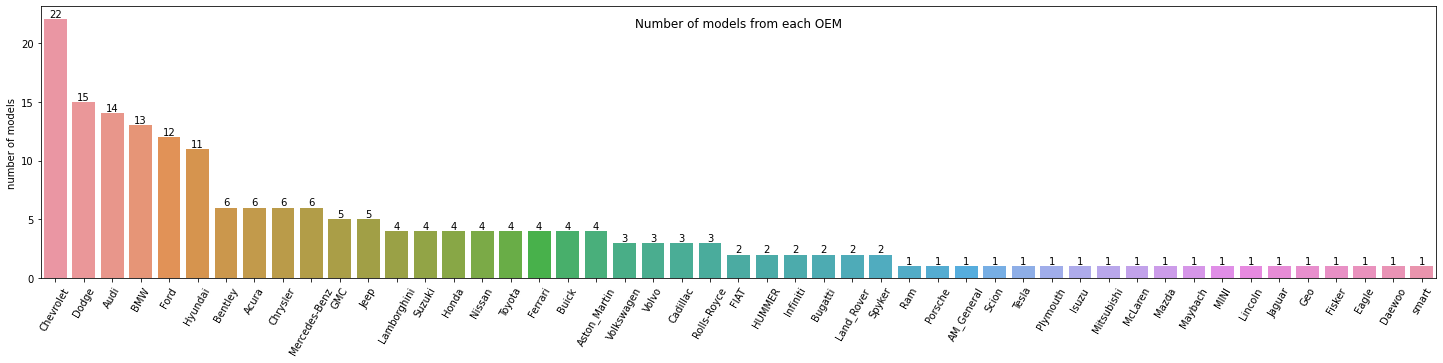

In [25]:
# Number of models from each OEM
plt.figure(figsize = (25,5))
ax = sns.barplot(x=carsMaster["OEM"].value_counts().index,y=carsMaster["OEM"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of models from each OEM",x=0.5,y=0.9)
plt.ylabel("number of models")
plt.xticks(rotation=60);

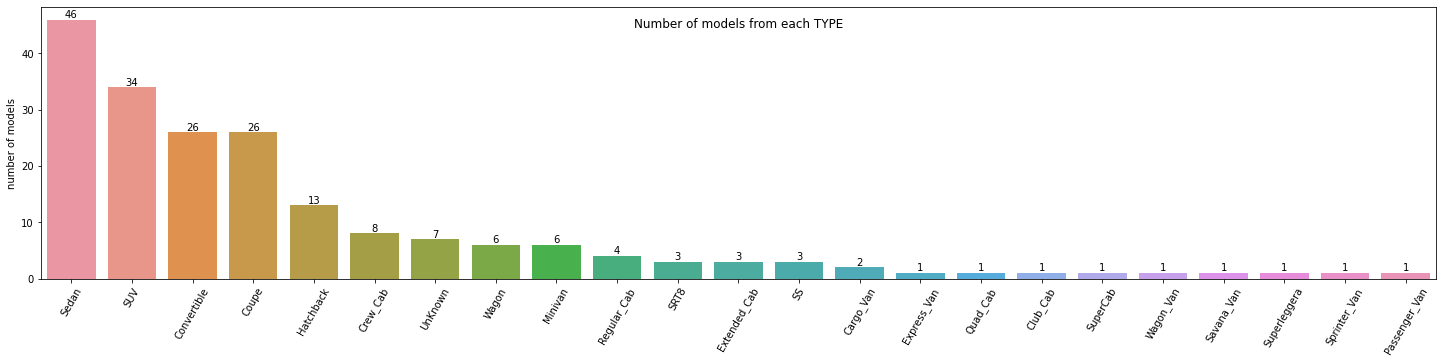

In [26]:
# Number of models from each TYPE of coach
plt.figure(figsize = (25,5))
ax = sns.barplot(x=carsMaster["TYPE"].value_counts().index,y=carsMaster["TYPE"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of models from each TYPE",x=0.5,y=0.9)
plt.ylabel("number of models")
plt.xticks(rotation=60);

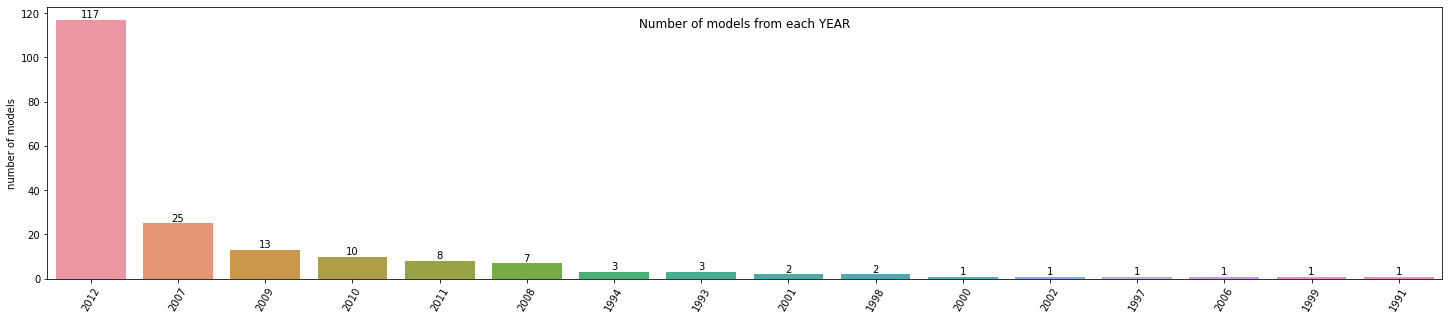

In [27]:
# Number of models from each YEAR
plt.figure(figsize = (25,5))
ax = sns.barplot(x=carsMaster["YEAR"].value_counts().index,y=carsMaster["YEAR"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of models from each YEAR",x=0.5,y=0.9)
plt.ylabel("number of models")
plt.xticks(rotation=60);

there are imbalances in the dataset might create bias in the model's capabilities

Lets also read the image data files in to our notebook, and review the distribution once again

In [28]:
# reference paths
BASEfldr = 'Car Images/'
TRAINfldr = 'Train Images/'
TESTfldr = 'Test Images/'

In [29]:
# lets take a record of data about the training imagess
path = BASEfldr+TRAINfldr
iCols = ["Image","ImagePath","folderName","height","width"]
imageMasterTrain = pd.DataFrame(columns=iCols)
imPath = np.empty(0)
fldrName = np.empty(0)
imageName = np.empty(0)
imH = np.empty(0)
imW = np.empty(0)
for cls in tqdm(carsMaster.fullNames,desc="imScanTrain"):
    try:
        os.listdir(path+cls)
    except:
        print("path error: ",path+cls)
        continue
    for img in os.listdir(path+cls):
        imPath = np.append(imPath,np.array([path+cls+'/'+img]))
        fldrName = np.append(fldrName,np.array([cls]))
        imageName = np.append(imageName,np.array([img]))
        (h,w) = Image.open(path+cls+'/'+img).size
        imH = np.append(imH,np.array([h]))
        imW = np.append(imW,np.array([w]))
imageMasterTrain["Image"] = imageName
imageMasterTrain["ImagePath"] = imPath
imageMasterTrain["folderName"] = fldrName
imageMasterTrain["height"] = imH
imageMasterTrain["width"] = imW

imScanTrain: 100%|████████████████████████████| 196/196 [00:05<00:00, 36.40it/s]


In [30]:
# lets take a record of data about the testing imagess
path = BASEfldr+TESTfldr
iCols = ["Image","ImagePath","folderName","height","width"]
imageMasterTest = pd.DataFrame(columns=iCols)
imPath = np.empty(0)
fldrName = np.empty(0)
imageName = np.empty(0)
imH = np.empty(0)
imW = np.empty(0)
for cls in tqdm(carsMaster.fullNames,desc="imScanTest"):
    try:
        os.listdir(path+cls)
    except:
        print("path error: ",cls)
        continue
    for img in os.listdir(path+cls):
        imPath = np.append(imPath,np.array([path+cls+'/'+img]))
        fldrName = np.append(fldrName,np.array([cls]))
        imageName = np.append(imageName,np.array([img]))
        (h,w) = Image.open(path+cls+'/'+img).size
        imH = np.append(imH,np.array([h]))
        imW = np.append(imW,np.array([w]))
imageMasterTest["Image"] = imageName
imageMasterTest["ImagePath"] = imPath
imageMasterTest["folderName"] = fldrName
imageMasterTest["height"] = imH
imageMasterTest["width"] = imW

imScanTest: 100%|█████████████████████████████| 196/196 [00:04<00:00, 39.26it/s]


In [31]:
# compute image sizes
imageMasterTrain["pixels"] = imageMasterTrain.height * imageMasterTrain.width
imageMasterTest["pixels"] = imageMasterTest.height * imageMasterTest.width

In [32]:
print("largest image:"),display(imageMasterTrain.loc[imageMasterTrain.pixels.argmax()].to_frame().T)
print("tallest image:"),display(imageMasterTrain.loc[imageMasterTrain.height.argmax()].to_frame().T)
print("widest image:"),display(imageMasterTrain.loc[imageMasterTrain.width.argmax()].to_frame().T)
print("\n")
print("smallest image:"),display(imageMasterTrain.loc[imageMasterTrain.pixels.argmin()].to_frame().T)
print("shortest image:"),display(imageMasterTrain.loc[imageMasterTrain.height.argmin()].to_frame().T)
print("leanest image:"),display(imageMasterTrain.loc[imageMasterTrain.width.argmin()].to_frame().T);

largest image:


Image                                          ImagePath  \
2573  05945.jpg  Car Images/Train Images/Chevrolet Sonic Sedan ...   

                      folderName  height   width      pixels  
2573  Chevrolet Sonic Sedan 2012  5616.0  3744.0  21026304.0

tallest image:


Image                                          ImagePath  \
2573  05945.jpg  Car Images/Train Images/Chevrolet Sonic Sedan ...   

                      folderName  height   width      pixels  
2573  Chevrolet Sonic Sedan 2012  5616.0  3744.0  21026304.0

widest image:


Image                                          ImagePath  \
2573  05945.jpg  Car Images/Train Images/Chevrolet Sonic Sedan ...   

                      folderName  height   width      pixels  
2573  Chevrolet Sonic Sedan 2012  5616.0  3744.0  21026304.0



smallest image:


Image                                          ImagePath  \
2294  00097.jpg  Car Images/Train Images/Chevrolet Corvette Ron...   

                                           folderName height width  pixels  
2294  Chevrolet Corvette Ron Fellows Edition Z06 2007   78.0  58.0  4524.0

shortest image:


Image                                          ImagePath  \
2294  00097.jpg  Car Images/Train Images/Chevrolet Corvette Ron...   

                                           folderName height width  pixels  
2294  Chevrolet Corvette Ron Fellows Edition Z06 2007   78.0  58.0  4524.0

leanest image:


Image                                          ImagePath  \
5107  04047.jpg  Car Images/Train Images/Geo Metro Convertible ...   

                      folderName height width  pixels  
5107  Geo Metro Convertible 1993  101.0  57.0  5757.0

based on above review, we shall restrict the image size fed to the network at 50x50 pixels, so as not to detoriate lower resolution images and thus affect model capabilities

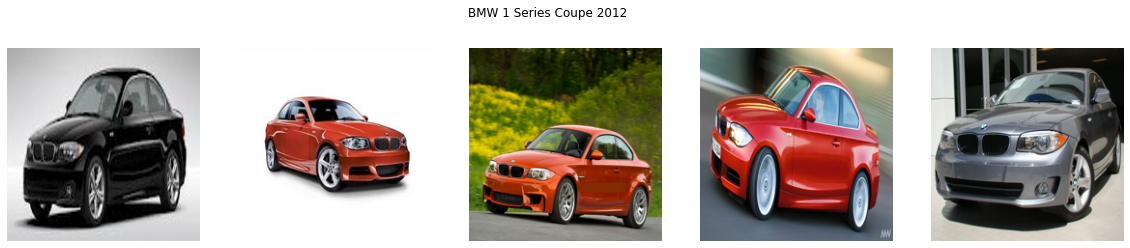

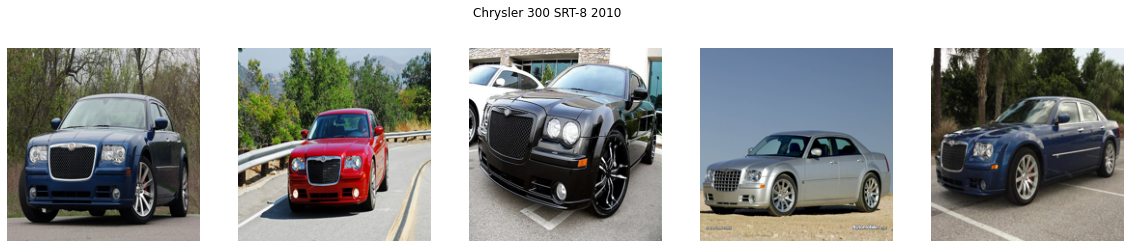

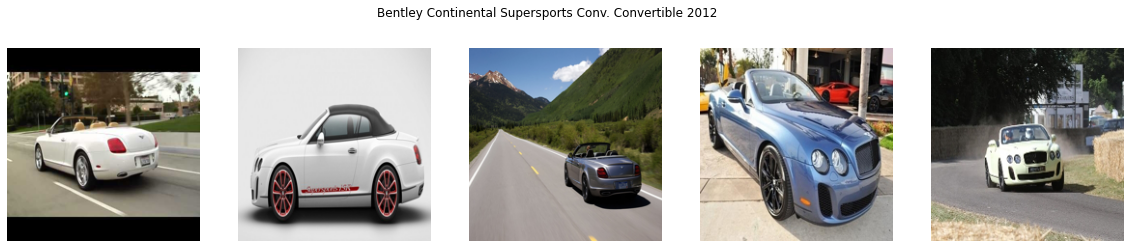

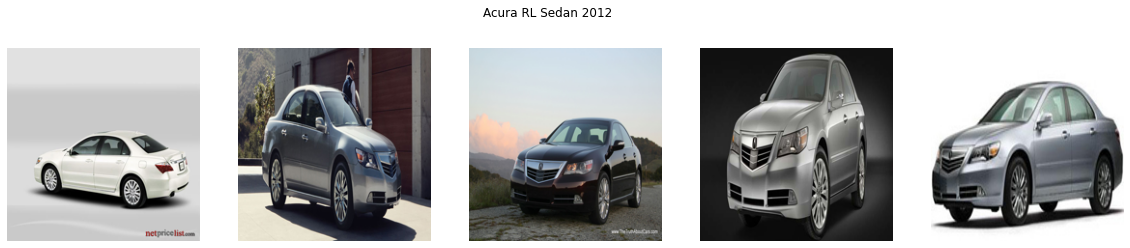

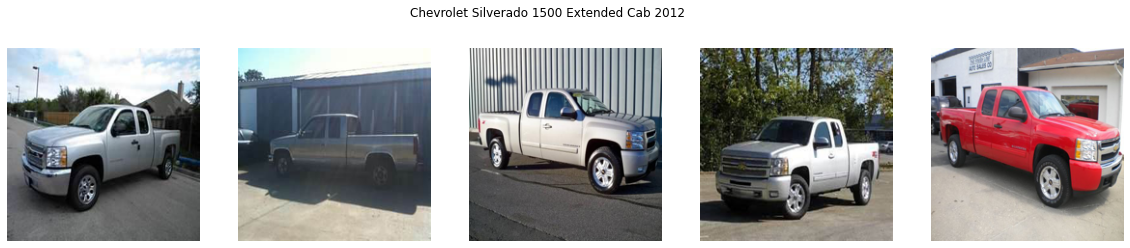

In [33]:
# display 5 random images of 5 random classes
classes = np.random.choice(imageMasterTrain.folderName.unique(),5,replace=False)
for cls in classes:
    dtmp = imageMasterTrain.loc[imageMasterTrain.folderName == cls]
    images = np.random.choice(dtmp.ImagePath.values,5,replace=False)
    plt.figure(figsize=(20,4))
    plt.suptitle(cls)
    for i,img in enumerate(images):
        img = Image.open(img).resize((200,200))
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

having connected to the images directories, lets also add the annotations, and add the bounding boxes to the images

In [34]:
# let us read the annotations datafile to pandas dataframe
trainAnnot = pd.read_csv('./Annotations/Train Annotations.csv')
testAnnot = pd.read_csv('./Annotations/Test Annotation.csv')
Acols = ['Image Name', 'x1', 'y1', 'x2','y2', 'Image class']
trainAnnot.columns = Acols
testAnnot.columns = Acols

In [35]:
#review the content
trainAnnot.head()

Image Name   x1   y1    x2    y2  Image class
0  00001.jpg   39  116   569   375           14
1  00002.jpg   36  116   868   587            3
2  00003.jpg   85  109   601   381           91
3  00004.jpg  621  393  1484  1096          134
4  00005.jpg   14   36   133    99          106

In [36]:
# create all-consildated dataframes
trainDF = pd.merge(imageMasterTrain,trainAnnot,how='outer',left_on='Image',right_on='Image Name')
testDF = pd.merge(imageMasterTest,testAnnot,how='outer',left_on='Image',right_on='Image Name')

display(trainDF.head(),testDF.head())

Image                                          ImagePath  \
0  04544.jpg  Car Images/Train Images/AM General Hummer SUV ...   
1  00163.jpg  Car Images/Train Images/AM General Hummer SUV ...   
2  00462.jpg  Car Images/Train Images/AM General Hummer SUV ...   
3  00522.jpg  Car Images/Train Images/AM General Hummer SUV ...   
4  00707.jpg  Car Images/Train Images/AM General Hummer SUV ...   

                   folderName  height  width    pixels Image Name  x1  y1  \
0  AM General Hummer SUV 2000   339.0  200.0   67800.0  04544.jpg  18  18   
1  AM General Hummer SUV 2000   700.0  525.0  367500.0  00163.jpg  46  84   
2  AM General Hummer SUV 2000    85.0   64.0    5440.0  00462.jpg   5   8   
3  AM General Hummer SUV 2000    94.0   71.0    6674.0  00522.jpg   6   7   
4  AM General Hummer SUV 2000   700.0  439.0  307300.0  00707.jpg  26  32   

    x2   y2  Image class  
0  328  190            1  
1  661  428            1  
2   83   58            1  
3   94   68            1  
4  677  418            1

Image                                          ImagePath  \
0  03246.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
1  00076.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
2  00457.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
3  00684.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
4  01117.jpg  Car Images/Test Images/AM General Hummer SUV 2...   

                   folderName  height  width    pixels Image Name   x1  y1  \
0  AM General Hummer SUV 2000   101.0   41.0    4141.0  03246.jpg    9   3   
1  AM General Hummer SUV 2000    96.0   64.0    6144.0  00076.jpg   11  13   
2  AM General Hummer SUV 2000   250.0  144.0   36000.0  00457.jpg   31  20   
3  AM General Hummer SUV 2000   373.0  216.0   80568.0  00684.jpg  111  54   
4  AM General Hummer SUV 2000   800.0  600.0  480000.0  01117.jpg   45  39   

    x2   y2  Image class  
0   93   41            1  
1   84   60            1  
2  226  119            1  
3  365  190            1  
4  729  414            1

In [37]:
# lets merge the OEM, MODEL, TYPE & YEAR data
trainDF = pd.merge(trainDF,carsMaster,how='outer',left_on='folderName',right_on='fullNames')
testDF = pd.merge(testDF,carsMaster,how='outer',left_on='folderName',right_on='fullNames')

In [38]:
# update class index to start from ZERO
trainDF["Image class"] = trainDF["Image class"]-1
testDF["Image class"] = testDF["Image class"]-1

In [39]:
# merge cars_names_and_make csv data with the annotation class name field
trainDF = pd.merge(trainDF,carsMaster,how='outer',left_on='Image class',right_index=True)
testDF = pd.merge(testDF,carsMaster,how='outer',left_on='Image class',right_index=True)
# though this will duplicate the already exisiting folderName, fullNames columns, this adds a cross check for data correctness

In [40]:
# review if any mismatches available
display(trainDF.loc[trainDF.folderName!=trainDF.fullNames_x])
display(trainDF.loc[trainDF.folderName!=trainDF.fullNames_y])
display(trainDF.loc[trainDF.fullNames_x!=trainDF.fullNames_y])
display(testDF.loc[testDF.folderName!=testDF.fullNames_x])
display(testDF.loc[testDF.folderName!=testDF.fullNames_y])
display(testDF.loc[testDF.fullNames_x!=testDF.fullNames_y])

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

having cross merged and synced with "Train/Test Annotations.csv", "Car names and make.csv" and the images in the "Train/Test images folders",<br>
it is found to have no mismatch of information. lets us try now remove unwanted columns and make the dataframe more readable

In [41]:
# finalize the images dataframe
trainDF = trainDF[["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image class","OEM_x","MODEL_x","TYPE_x","YEAR_x",]]
testDF = testDF[["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image class","OEM_x","MODEL_x","TYPE_x","YEAR_x",]]

trainDF.columns = ["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image_class","OEM","MODEL","TYPE","YEAR"]
testDF.columns = ["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image_class","OEM","MODEL","TYPE","YEAR"]


In [42]:
# lest encode the classes into binaries
enc = LabelBinarizer()
trainDF["classEncoded"] = list(enc.fit_transform(trainDF.Image_class.values.reshape(-1, 1)))
testDF["classEncoded"] = list(enc.transform(testDF.Image_class.values.reshape(-1, 1)))

In [43]:
# concatenate target columns (for ImageDatagenerator)
trainDF["bBox"] = trainDF.apply(lambda row: [row.x1,row.y1,row.x2,row.y2],axis=1).values.copy()
testDF["bBox"] = testDF.apply(lambda row: [row.x1,row.y1,row.x2,row.y2],axis=1).values.copy()

In [44]:
trainDF.sample(2)

Image                                          ImagePath   x1   y1  \
4066  04255.jpg  Car Images/Train Images/FIAT 500 Abarth 2012/0...  169  129   
4535  06929.jpg  Car Images/Train Images/Ford Edge SUV 2012/069...    7   31   

       x2   y2  height  width            folderName  Image_class   OEM  \
4066  414  278   500.0  333.0  FIAT 500 Abarth 2012           98  FIAT   
4535  294  214   300.0  225.0    Ford Edge SUV 2012          109  Ford   

           MODEL     TYPE  YEAR  \
4066  500_Abarth  UnKnown  2012   
4535        Edge      SUV  2012   

                                           classEncoded                  bBox  
4066  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [169, 129, 414, 278]  
4535  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     [7, 31, 294, 214]

In [45]:
testDF.sample(2)

Image                                          ImagePath  x1  y1  \
6179  06772.jpg  Car Images/Test Images/Lamborghini Aventador C...  55  40   
2083  06637.jpg  Car Images/Test Images/Cadillac SRX SUV 2012/0...   7   1   

       x2   y2  height  width                        folderName  Image_class  \
6179  546  286   590.0  360.0  Lamborghini Aventador Coupe 2012          150   
2083  491  313   500.0  315.0             Cadillac SRX SUV 2012           51   

              OEM      MODEL   TYPE  YEAR  \
6179  Lamborghini  Aventador  Coupe  2012   
2083     Cadillac        SRX    SUV  2012   

                                           classEncoded                bBox  
6179  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [55, 40, 546, 286]  
2083  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    [7, 1, 491, 313]

In [46]:
# review for any missing values
trainDF.isna().sum()

Image           0
ImagePath       0
x1              0
y1              0
x2              0
y2              0
height          0
width           0
folderName      0
Image_class     0
OEM             0
MODEL           0
TYPE            0
YEAR            0
classEncoded    0
bBox            0
dtype: int64

In [47]:
testDF.isna().sum()

Image           0
ImagePath       0
x1              0
y1              0
x2              0
y2              0
height          0
width           0
folderName      0
Image_class     0
OEM             0
MODEL           0
TYPE            0
YEAR            0
classEncoded    0
bBox            0
dtype: int64

2022-07-04 23:49:33.591871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:49:33.623535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:49:33.623693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:49:33.624305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

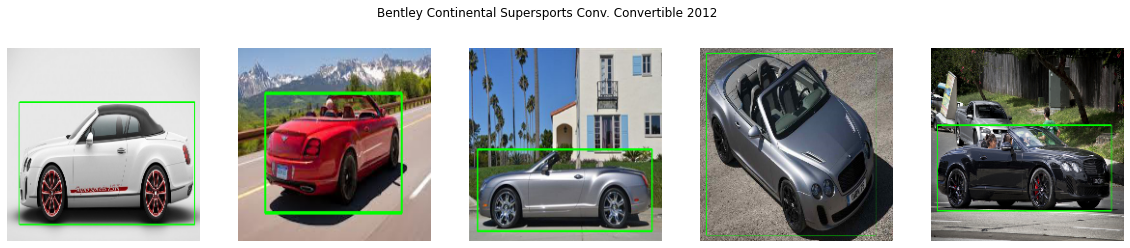

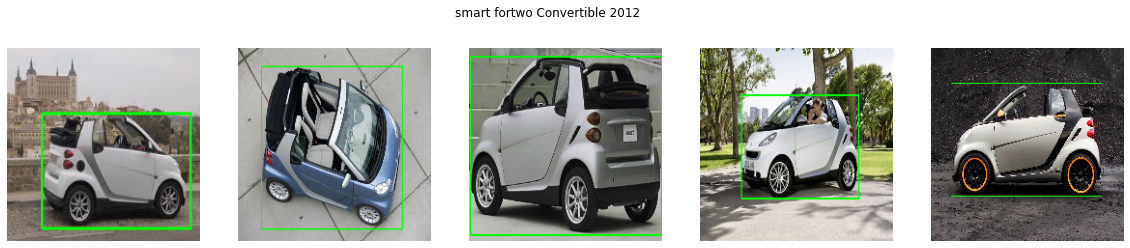

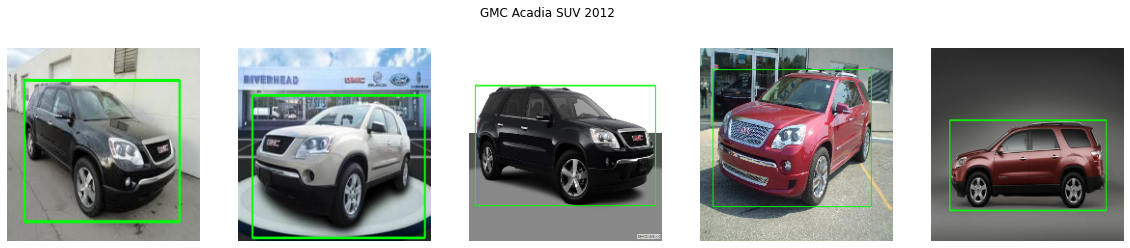

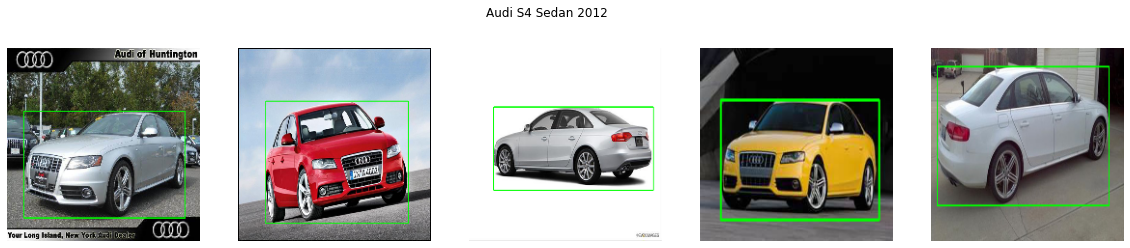

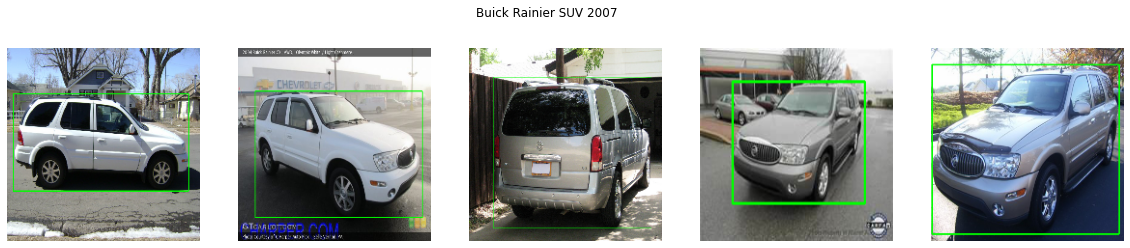

In [48]:
# display 5 random images of 5 random classes with respective bounding boxes from the annotations csv
classes = np.random.choice(trainDF.folderName.unique(),5,replace=False)
tfi = tf.keras.preprocessing.image
for cls in classes:
    dtmp = trainDF.loc[trainDF.folderName == cls]
    ind = np.random.choice(dtmp.index,5,replace=False)
    images = dtmp.loc[ind]["ImagePath"]
    x1 = dtmp.loc[ind]["x1"].values
    y1 = dtmp.loc[ind]["y1"].values
    x2 = dtmp.loc[ind]["x2"].values
    y2 = dtmp.loc[ind]["y2"].values

    plt.figure(figsize=(20,4))
    plt.suptitle(cls)
    for i,img in enumerate(images):
        img = tfi.img_to_array(tfi.load_img(img))
        cv2.rectangle(img,(x1[i],y1[i]),(x2[i],y2[i]),(0,255,0),2)
        img = tfi.array_to_img(tf.image.resize(img,(200,200)))
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

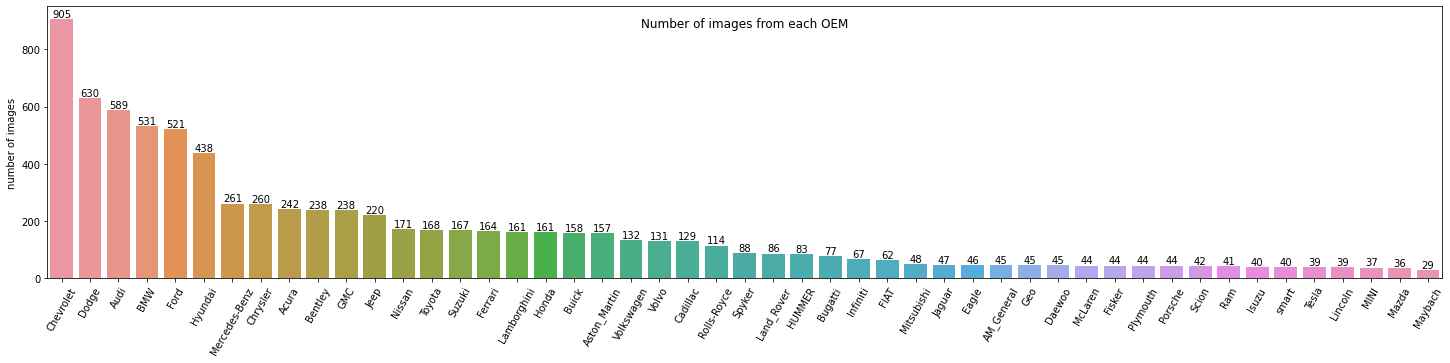

In [49]:
# Number of images from each OEM
plt.figure(figsize = (25,5))
ax = sns.barplot(x=trainDF["OEM"].value_counts().index,y=trainDF["OEM"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of images from each OEM",x=0.5,y=0.9)
plt.ylabel("number of images")
plt.xticks(rotation=60);

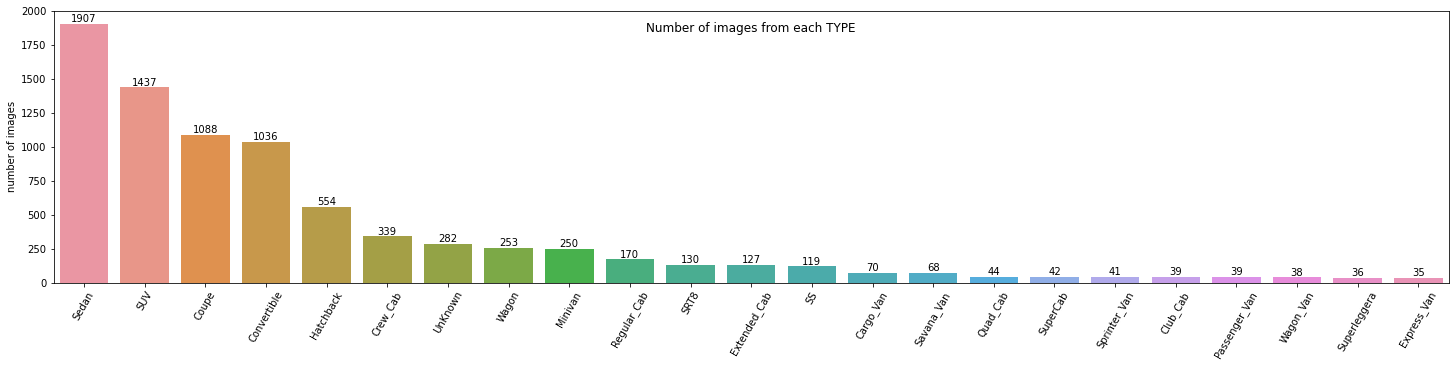

In [50]:
# Number of images from each OEM
plt.figure(figsize = (25,5))
ax = sns.barplot(x=trainDF["TYPE"].value_counts().index,y=trainDF["TYPE"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of images from each TYPE",x=0.5,y=0.9)
plt.ylabel("number of images")
plt.xticks(rotation=60);

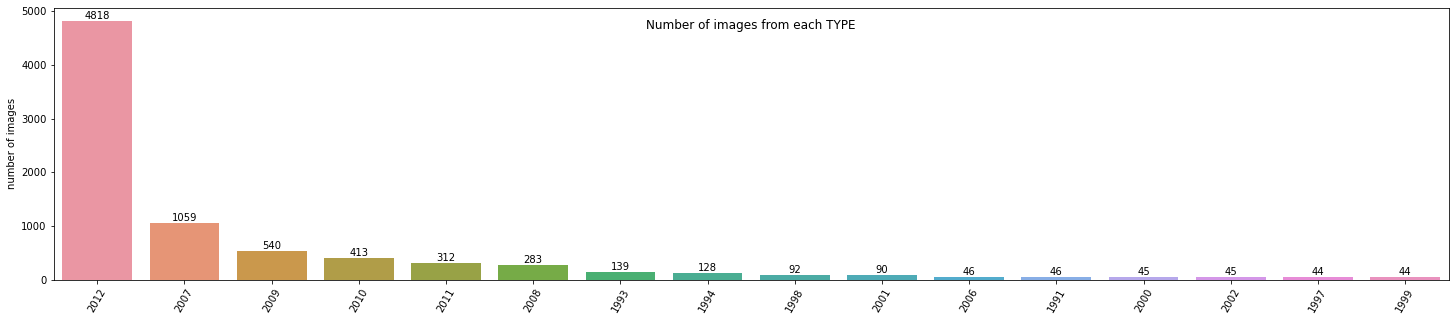

In [51]:
# Number of images from each OEM
plt.figure(figsize = (25,5))
ax = sns.barplot(x=trainDF["YEAR"].value_counts().index,y=trainDF["YEAR"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of images from each TYPE",x=0.5,y=0.9)
plt.ylabel("number of images")
plt.xticks(rotation=60);

Text(0.1, 0.9, 'distribution of support for each class')

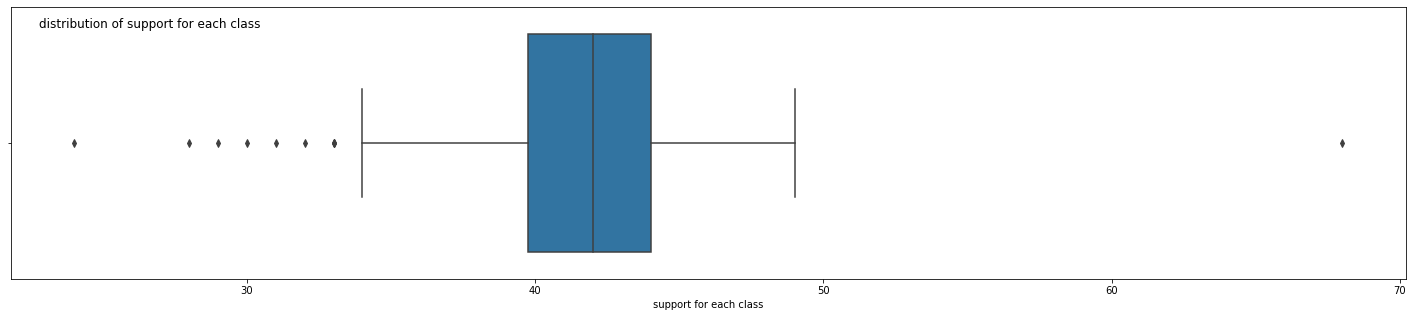

In [52]:
# distribution of support for each class
plt.figure(figsize = (25,5))
sns.boxplot(x=trainDF["folderName"].value_counts())
plt.xlabel("support for each class")
plt.title("distribution of support for each class",x=0.1,y=0.9)

All the data preprocessing & compilation have been completed so far<br>
The data were imported and mapped against their respectivee classses & annotations<br>
Comprehensive dataframes for training & testing datasets were created and could be used with generators for Deep Learning Networks<br>
### **MILESTONE 1 COMPLETE**


for future codes, import the following dataframes as final output from this Milestone1<br>
* trainDF
* testDF

use following code to invoke & import data<br>
***from*** Milestone1 ***import*** trainDF, testDF;